# **Customer Churn Prediction Model**

The primary objective of this project is to develop a machine learning model capable of predicting customer churn for a telecom company. Customer churn occurs when customers stop using a company's services, and accurately predicting it can help the business take preventive actions. The project includes data preprocessing, model training, evaluation, and deploying the model on a free deployment platform, making it accessible online for real-time predictions.

### **Problem Statement**
Telecommunication companies face significant challenges in retaining customers due to competitive pressures and the availability of multiple service providers. High customer churn rates negatively impact revenue and customer acquisition efforts. Understanding and predicting churn behavior allows companies to identify at-risk customers and apply targeted interventions. In this project, we aim to address the problem of customer churn by leveraging customer demographic and service usage data to create a predictive model that can help the telecom company reduce churn rates and improve customer retention strategies.

### **Key Steps in the Project**

### 1. **Data Exploration and Preprocessing**
   - Load and explore the customer dataset.
   - Perform data cleaning (handling missing values, duplicates, etc.).
   - Encode categorical variables and scale numerical variables.
   - Conduct exploratory data analysis (EDA) to uncover important patterns and relationships within the data.

### 2. **Feature Engineering**
   - Identify and select important features that contribute to predicting customer churn.
   - Engineer new features based on domain knowledge or by transforming existing variables to improve model performance.

### 3. **Model Training**
   - Split the data into training and test sets.
   - Train two machine learning models Random Forest and XGBoost.
   - Evaluate models using various performance metrics (accuracy, precision, recall, F1-score).

### 4. **Model Evaluation and Selection**
   - Compare the performance of different models.
   - Select the model with the best predictive performance based on evaluation metrics.
   - Fine-tune hyperparameters for the best model to enhance accuracy.

### 5. **Model Deployment**
   - Deploy the selected model on a free deployment platform such as Heroku or Streamlit.
   - Set up an API or web-based interface to allow for real-time predictions and accessibility.

### 6. **User Interface**
   - Design a simple, user-friendly interface where users can input customer details and receive churn predictions.
   - Provide clear documentation on how to use the interface and interpret the model's predictions.

### 7. **Documentation and Presentation**
   - Document all steps of the project, including data preprocessing, model training, and deployment.
   - Prepare a presentation or report that summarizes the findings, model performance, and practical applications.


### **Step 1: Data Exploration and Preprocessing**

In [59]:
# -------------------------- Import Libraries --------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import xgboost as xgb
import joblib

# Set up warnings filter and seaborn style
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

In [50]:
# -------------------------- Load Dataset --------------------------

file_path = r"C:\Users\USER\Downloads\Customer Churn Prediction Model\Telecoms Company data.xlsx"

# Load the dataset
data = pd.read_excel(file_path)

# Display the first few rows of the dataset
print("Dataset loaded successfully. Here are the first 5 rows:")
print(data.head())

# Check for missing values
print("\nMissing Values in Each Column:")
print(data.isnull().sum())

# Basic statistics and data info
print("\nDataset Info:")
data.info()

print("\nDescriptive Statistics:")
print(data.describe())

Dataset loaded successfully. Here are the first 5 rows:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  Tech

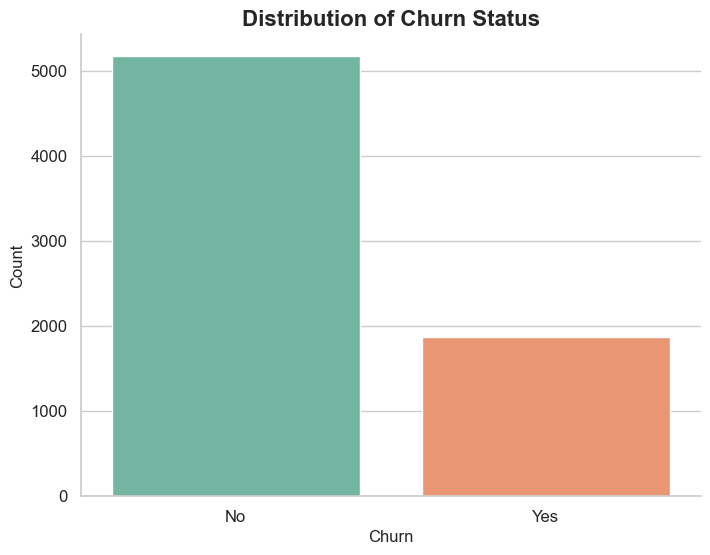

In [51]:
# -------------------------- Visualise Churn Distribution --------------------------

# A churn distribution plot
plt.figure(figsize=(8,6))
sns.countplot(x='Churn', data=data, palette="Set2")  # Use a nice colour palette
plt.title('Distribution of Churn Status', fontsize=16, fontweight='bold')
plt.xlabel('Churn', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.despine()  # Remove top and right spines for a cleaner look
plt.show()

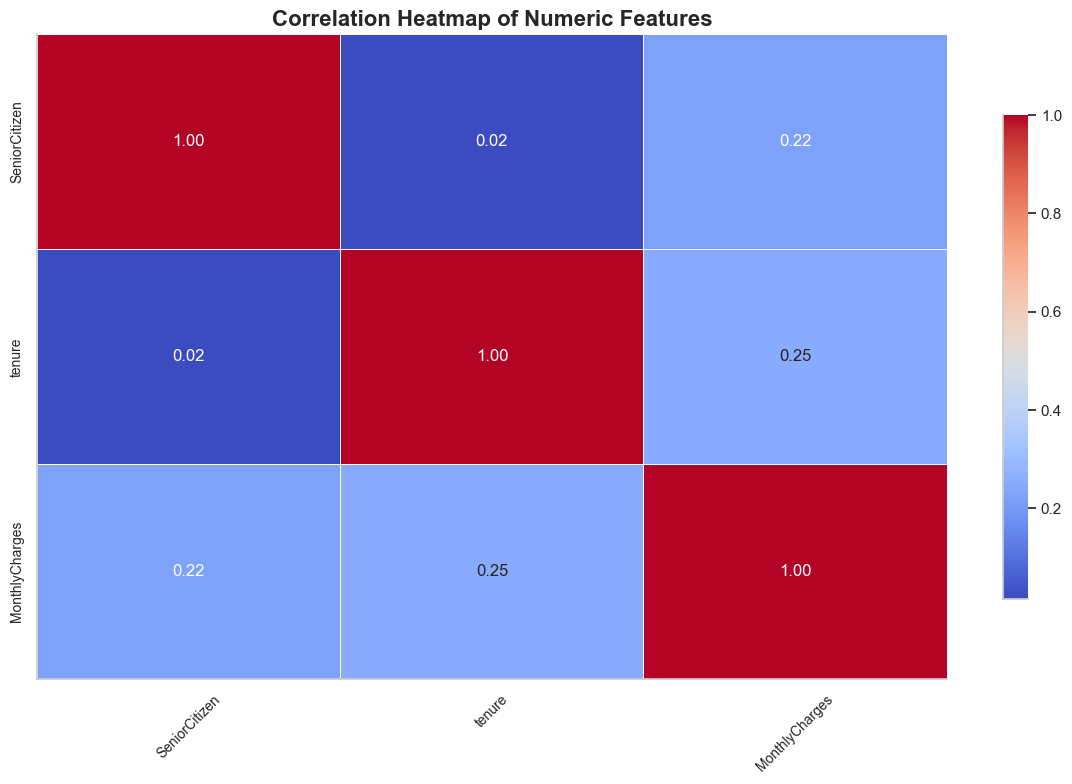

In [52]:
# -------------------------- Visualise Correlations --------------------------

# Filter out non-numeric columns
numeric_data = data.select_dtypes(include=[np.number])

# Visualise correlations between numeric features using a compelling colour map
plt.figure(figsize=(12,8))
heatmap = sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, 
                      cbar_kws={"shrink": 0.75})  # Add colour bar for better context

# Enhance the heatmap
plt.title('Correlation Heatmap of Numeric Features', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, fontsize=10)  # Rotate x-axis labels for readability
plt.yticks(fontsize=10)
plt.tight_layout()  # Adjust layout to fit everything nicely
sns.despine()  # Remove unnecessary spines
plt.show()

### **Step 2: Feature Engineering**

In [53]:
# -------------------------- Feature Engineering --------------------------

# Step 1: Drop 'customerID' column if it exists
data = data.drop(columns=['customerID'], errors='ignore')

# Step 2: Encode binary categorical variables
binary_columns = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']

label_enc = LabelEncoder()
for column in binary_columns:
    if column in data.columns:  # Check if column exists
        data[column] = label_enc.fit_transform(data[column].astype(str))

# Step 3: One-Hot Encoding for multi-class categorical variables
multi_class_columns = ['InternetService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 
                       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 
                       'Contract', 'PaymentMethod']

# Check if all columns in multi_class_columns exist in the data
existing_columns = [col for col in multi_class_columns if col in data.columns]

if not existing_columns:
    print("None of the specified multi-class columns exist in the DataFrame.")
else:
    # Apply one-hot encoding for existing columns
    data = pd.get_dummies(data, columns=existing_columns, drop_first=True)

# Step 4: Convert 'MonthlyCharges', 'TotalCharges', and 'tenure' to numeric, coercing errors to NaN
data['MonthlyCharges'] = pd.to_numeric(data['MonthlyCharges'], errors='coerce')
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
data['tenure'] = pd.to_numeric(data['tenure'], errors='coerce')

# Fill NaN values in 'TotalCharges' with 0 (or another strategy, e.g., mean or median)
data['TotalCharges'] = data['TotalCharges'].fillna(0)

# Step 5: Create new features
# LongTermCustomer flag: customers with tenure > 12 months
data['LongTermCustomer'] = (data['tenure'] > 12).astype(int)

# Average Monthly Charges
data['AvgMonthlyCharge'] = data['MonthlyCharges'] / (data['tenure'] + 1)  # Prevent division by zero

# Total Charges per Tenure
data['TotalChargesPerTenure'] = data['TotalCharges'] / (data['tenure'] + 1)

# HasMultipleServices flag: If customer uses multiple services
if all(col in data.columns for col in ['OnlineSecurity_Yes', 'OnlineBackup_Yes', 'DeviceProtection_Yes', 
                                       'TechSupport_Yes', 'StreamingTV_Yes', 'StreamingMovies_Yes']):
    data['HasMultipleServices'] = (
        data[['OnlineSecurity_Yes', 'OnlineBackup_Yes', 'DeviceProtection_Yes', 
              'TechSupport_Yes', 'StreamingTV_Yes', 'StreamingMovies_Yes']].sum(axis=1) > 1
    ).astype(int)

# LongTermContract flag: Customers with either One-year or Two-year contract
if all(col in data.columns for col in ['Contract_One year', 'Contract_Two year']):
    data['LongTermContract'] = (data['Contract_One year'] | data['Contract_Two year']).astype(int)

# Step 6: Ensure all values are numeric
data = data.apply(pd.to_numeric, errors='coerce')

# Step 7: Handle NaN values if present
if data.isnull().sum().any():
    print("\nThere are NaN values in the DataFrame after conversion:")
    print(data.isnull().sum())
    data = data.fillna(0)  # Handle NaN values by filling with 0 or an appropriate strategy

# Step 8: Feature importance using RandomForestClassifier
X = data.drop('Churn', axis=1)  # Features
y = data['Churn']  # Target

# Initialize and train a random forest model
model = RandomForestClassifier(random_state=42)
model.fit(X, y)

# Feature Importance
feature_importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Feature Importance:\n", feature_importance)

# Display the final DataFrame after feature engineering
print("\nFinal DataFrame after encoding and feature engineering:")
print(data.head())

Feature Importance:
 AvgMonthlyCharge                         0.164670
TotalCharges                             0.115165
MonthlyCharges                           0.110709
TotalChargesPerTenure                    0.110092
tenure                                   0.088448
LongTermContract                         0.047374
PaymentMethod_Electronic check           0.030602
LongTermCustomer                         0.026391
InternetService_Fiber optic              0.025376
gender                                   0.021732
PaperlessBilling                         0.021244
Partner                                  0.017593
OnlineSecurity_Yes                       0.017040
SeniorCitizen                            0.016697
TechSupport_Yes                          0.016283
OnlineBackup_Yes                         0.015081
Dependents                               0.014849
MultipleLines_Yes                        0.014561
Contract_Two year                        0.014398
DeviceProtection_Yes         

### **Step 3: Model Training**

In [54]:
# ------------------------ Model Training and Evaluation ------------------------

# Split data into features (X) and target (y)
X = data.drop('Churn', axis=1)  # Features (drop 'Churn' column)
y = data['Churn']  # Target (Churn column)

# Split the dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [55]:
# ---------------------------- Model 1: Random Forest ----------------------------

# Train the Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions with the Random Forest model
y_pred_rf = rf_model.predict(X_test)

# Evaluate Random Forest Model
print("\n--- Random Forest Evaluation ---")

# Calculate Accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest Accuracy: {accuracy_rf:.4f}')

# Calculate Precision
precision_rf = precision_score(y_test, y_pred_rf)
print(f'Random Forest Precision: {precision_rf:.4f}')

# Calculate Recall
recall_rf = recall_score(y_test, y_pred_rf)
print(f'Random Forest Recall: {recall_rf:.4f}')

# Calculate F1-score
f1_rf = f1_score(y_test, y_pred_rf)
print(f'Random Forest F1-score: {f1_rf:.4f}')

# Display the classification report
print("\nClassification Report (Random Forest):")
print(classification_report(y_test, y_pred_rf))

# Confusion Matrix for Random Forest
print("\nConfusion Matrix (Random Forest):")
print(confusion_matrix(y_test, y_pred_rf))


--- Random Forest Evaluation ---
Random Forest Accuracy: 0.7892
Random Forest Precision: 0.6377
Random Forest Recall: 0.4718
Random Forest F1-score: 0.5424

Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1036
           1       0.64      0.47      0.54       373

    accuracy                           0.79      1409
   macro avg       0.73      0.69      0.70      1409
weighted avg       0.78      0.79      0.78      1409


Confusion Matrix (Random Forest):
[[936 100]
 [197 176]]


In [56]:
# ---------------------------- Model 2: XGBoost ----------------------------

# Train the XGBoost Classifier
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions with the XGBoost model
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate XGBoost Model
print("\n--- XGBoost Evaluation ---")

# Calculate Accuracy
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f'XGBoost Accuracy: {accuracy_xgb:.4f}')

# Calculate Precision
precision_xgb = precision_score(y_test, y_pred_xgb)
print(f'XGBoost Precision: {precision_xgb:.4f}')

# Calculate Recall
recall_xgb = recall_score(y_test, y_pred_xgb)
print(f'XGBoost Recall: {recall_xgb:.4f}')

# Calculate F1-score
f1_xgb = f1_score(y_test, y_pred_xgb)
print(f'XGBoost F1-score: {f1_xgb:.4f}')

# Display the classification report
print("\nClassification Report (XGBoost):")
print(classification_report(y_test, y_pred_xgb))

# Confusion Matrix for XGBoost
print("\nConfusion Matrix (XGBoost):")
print(confusion_matrix(y_test, y_pred_xgb))


--- XGBoost Evaluation ---
XGBoost Accuracy: 0.7864
XGBoost Precision: 0.6139
XGBoost Recall: 0.5201
XGBoost F1-score: 0.5631

Classification Report (XGBoost):
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1036
           1       0.61      0.52      0.56       373

    accuracy                           0.79      1409
   macro avg       0.73      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409


Confusion Matrix (XGBoost):
[[914 122]
 [179 194]]


### **Step 4: Model Evaluation and Selection**

In [57]:
# ---------------------------- Compare Performance ----------------------------

print("\n--- Model Performance Comparison ---")
print(f"Random Forest: Accuracy={rf_accuracy:.4f}, Precision={rf_precision:.4f}, Recall={rf_recall:.4f}, F1-score={rf_f1:.4f}")
print(f"XGBoost: Accuracy={xgb_accuracy:.4f}, Precision={xgb_precision:.4f}, Recall={xgb_recall:.4f}, F1-score={xgb_f1:.4f}")

# Select the best model based on F1-score
if rf_f1 > xgb_f1:
    best_model = rf_model
    best_model_name = "Random Forest"
else:
    best_model = xgb_model
    best_model_name = "XGBoost"

print(f"\nBest Model: {best_model_name} with F1-score: {max(rf_f1, xgb_f1):.4f}")


--- Model Performance Comparison ---
Random Forest: Accuracy=0.7892, Precision=0.6377, Recall=0.4718, F1-score=0.5424
XGBoost: Accuracy=0.7864, Precision=0.6139, Recall=0.5201, F1-score=0.5631

Best Model: XGBoost with F1-score: 0.5631


In [58]:
# ---------------------------- Hyperparameter Tuning ----------------------------

# Define parameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
}

# Perform Grid Search for Random Forest
rf_grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), 
                               param_grid=rf_param_grid, 
                               scoring='f1', 
                               cv=5)
rf_grid_search.fit(X_train, y_train)

# Print the best hyperparameters for Random Forest
print("\nBest Hyperparameters for Random Forest:")
print(rf_grid_search.best_params_)


Best Hyperparameters for Random Forest:
{'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}


### **Step 5: Model Deployment**

In [60]:
# -------------------------- Model Deployment -------------------------- 

# Save the best model
best_rf_model = rf_grid_search.best_estimator_  # Assuming you want to save Random Forest
joblib.dump(best_rf_model, 'best_rf_model.pkl')

['best_rf_model.pkl']